# Connect ke GDrive

In [ ]:
# Menghubungkan Google Colab dengan Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Membuat folder proyek di Google Drive
import os
project_path = "/content/drive/MyDrive/IR"
os.makedirs(project_path, exist_ok=True)
print(f"Folder siap di: {project_path}")

Mounted at /content/drive
Folder siap di: /content/drive/MyDrive/IR


# A. Set Library dan Dataset

In [ ]:
pip install Sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 15.9 MB/s eta 0:00:00


In [ ]:
pip install googletrans

In [ ]:
pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import re

try:
    from deep_translator import GoogleTranslator
    USE_DEEP_TRANSLATOR = True
except ImportError:
    from googletrans import Translator
    USE_DEEP_TRANSLATOR = False

df = pd.read_csv("/content/drive/MyDrive/IR/bahlil_label - Sheet1.csv")

def clean_text(text):
  text = str(text).lower()
  text = re.sub(r'\bamp\b', '', text)
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\s+', ' ', text).strip()
  return text

def back_translate(text, target_lang='en'):
    if USE_DEEP_TRANSLATOR:
        try:
            # Using deep_translator
            translator_to_en = GoogleTranslator(source='id', target=target_lang)
            translated_text_en = translator_to_en.translate(text)

            translator_to_id = GoogleTranslator(source=target_lang, target='id')
            back_translated_text_id = translator_to_id.translate(translated_text_en)

            return back_translated_text_id
        except Exception as e:
            print(f"Translation error with deep_translator for text '{text[:30]}...': {e}")
            return text
    else:
        # Fallback to googletrans
        translator = Translator()
        try:
            time.sleep(0.5)
            trans = translator.translate(text, src='id', dest=target_lang).text
            time.sleep(0.5)
            back_trans = translator.translate(trans.text, src=target_lang, dest='id').text
            return back_trans.text
        except Exception as e:
            print(f"Translation error with googletrans for text '{text[:30]}...': {e}")
            return text

if 'clean_text' not in df.columns:
    print("Cleaning text...")
    df['clean_text'] = df['text'].apply(clean_text)

df_aug = df.copy()
new_rows = []
start_time = time.time()

label_counts = df['label_sentimen'].value_counts()
print(f"label distribution:\n{label_counts}\n")

for index, row in df.iterrows():
  label = row['label_sentimen']
  text = row['clean_text']

  if label in ['NEUTRAL','POSITIVE']:
    bt_text = back_translate(text)
    if bt_text is not None and bt_text.lower() != text.lower():
      new_rows.append({'clean_text': bt_text, 'label_sentimen': label})

  if (index + 1) % 10 == 0:
        elapsed = time.time() - start_time
        print(f"Processed {index + 1}/{len(df)} rows | Time: {elapsed:.2f}s")

if len(new_rows) > 0:
  df_clean = pd.concat([df_aug, pd.DataFrame(new_rows)], ignore_index=True)
else:
  df_clean = df_aug

df_clean = df_clean.dropna(subset=['clean_text', 'label_sentimen']).copy()
df_clean = df_clean.drop(columns=['Unnamed: 3'])
df_clean["label_sentimen_encoded"], uniques = pd.factorize(df_clean["label_sentimen"])

print(uniques)
print('\n', df_clean["label_sentimen_encoded"].unique())
print(df_clean.head())

df_train, df_test = train_test_split(df_clean, test_size=0.3, random_state=42, stratify=df_clean['label_sentimen_encoded'])

label distribution:
label_sentimen
NEGATIVE    425
NEUTRAL     209
POSITIVE    129
Name: count, dtype: int64

Processed 10/763 rows | Time: 0.76s
Processed 20/763 rows | Time: 2.53s
Processed 30/763 rows | Time: 3.31s
Processed 40/763 rows | Time: 3.79s
Processed 50/763 rows | Time: 4.26s
Processed 60/763 rows | Time: 5.38s
Processed 70/763 rows | Time: 6.36s
Processed 80/763 rows | Time: 8.46s
Processed 90/763 rows | Time: 9.64s
Processed 100/763 rows | Time: 10.87s
Processed 110/763 rows | Time: 11.36s
Processed 120/763 rows | Time: 12.67s
Processed 130/763 rows | Time: 13.80s
Processed 140/763 rows | Time: 15.35s
Processed 150/763 rows | Time: 16.15s
Processed 160/763 rows | Time: 16.60s
Processed 170/763 rows | Time: 17.87s
Processed 180/763 rows | Time: 18.87s
Processed 190/763 rows | Time: 20.19s
Processed 200/763 rows | Time: 21.32s
Processed 210/763 rows | Time: 22.01s
Processed 220/763 rows | Time: 23.39s
Processed 230/763 rows | Time: 23.85s
Processed 240/763 rows | Time: 24.

# B. Analisis Data Eksploratif

label_sentimen_encoded
0    297
1    291
2    181
Name: count, dtype: int64


<Axes: xlabel='label_sentimen_encoded', ylabel='count'>

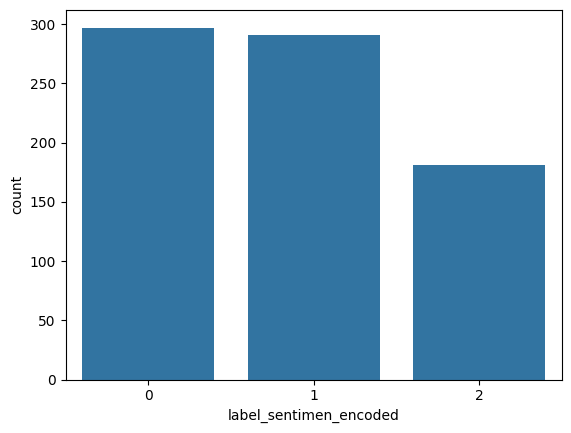

In [ ]:
x = df_train['label_sentimen_encoded'].value_counts()
print(x)
sns.barplot(x=x.index, y=x)

Jumlah sentimen negatif jauh lebih tinggi dibandingkan sentimen netral dan sentimen positif

In [ ]:
# cek missing values
df_train.isna().sum()
df_train.isnull().sum()

,0
id_text,234
clean_text,0
label_sentimen,0
label_sentimen_encoded,0


Tidak ada missing values dari data. Dengan demikian, dataset sudah bersih dan akan dilakukan analisis sentimen.

In [ ]:
# 1. WORD-COUNT
df_train['word_count'] = df_train['clean_text'].apply(lambda x:len(str(x).split()))
print(df_train[df_train['label_sentimen_encoded']==2]['word_count'].mean()) # positive
print(df_train[df_train['label_sentimen_encoded']==1]['word_count'].mean()) # neutral
print(df_train[df_train['label_sentimen_encoded']==0]['word_count'].mean()) # negative
# 2. CHAR-COUNT
df_train['char_count'] = df_train['clean_text'].apply(lambda x:len(str(x)))
print(df_train[df_train['label_sentimen_encoded']==2]['word_count'].mean()) # positive
print(df_train[df_train['label_sentimen_encoded']==1]['char_count'].mean()) # neutral
print(df_train[df_train['label_sentimen_encoded']==0]['char_count'].mean()) # negative
# 3. UNIQ-COUNT
df_train['uniq_count'] = df_train['clean_text'].apply(lambda x:len(set(str(x).split())))
print(df_train[df_train['label_sentimen_encoded']==2]['word_count'].mean()) # positive
print(df_train[df_train['label_sentimen_encoded']==1]['uniq_count'].mean()) # neutral
print(df_train[df_train['label_sentimen_encoded']==0]['uniq_count'].mean()) # negative

26.933701657458563
28.714776632302407
28.835016835016834
26.933701657458563
200.79381443298968
190.46127946127947
26.933701657458563
26.553264604810998
26.555555555555557


Menunjukkan jumlah kata, karakter, dan kata unik pada teks positif, netral, dan negatif.

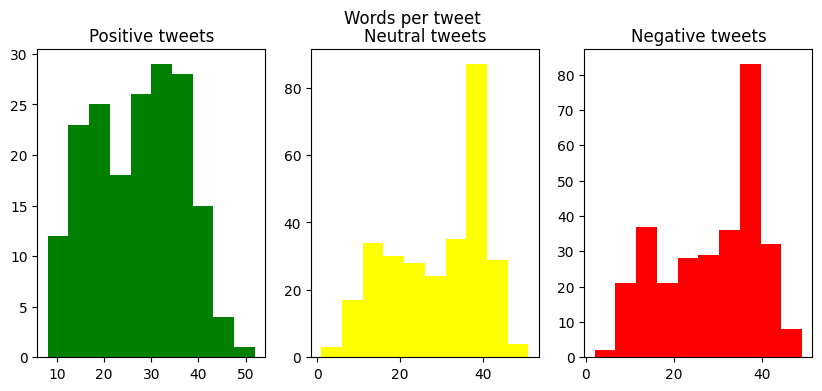

In [ ]:
# Plot woird-count per tweet
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,4))
train_words=df_train[df_train['label_sentimen_encoded']==2]['word_count']
ax1.hist(train_words,color='green')
ax1.set_title('Positive tweets')
fig.suptitle('Words per tweet')
train_words=df_train[df_train['label_sentimen_encoded']==1]['word_count']
ax2.hist(train_words,color='yellow')
ax2.set_title('Neutral tweets')
fig.suptitle('Words per tweet')
train_words=df_train[df_train['label_sentimen_encoded']==0]['word_count']
ax3.hist(train_words,color='red')
ax3.set_title('Negative tweets')
fig.suptitle('Words per tweet')
plt.show()

df_train=df_train.drop(columns=['word_count','char_count','uniq_count'])

Graffik menunjukkan bahwa tweet positif memiliki jumlah yang paling sedikit. Dapat dilihat tweet netral dann negatif memiliki puncak sekitar 40-45 kata per tweet.

# C. Teks Preprocessing

In [ ]:
import re
import string
import pandas as pd
import numpy as np
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

slang_dict = {
    'gak': 'tidak', 'ga': 'tidak', 'ngga': 'tidak', 'nggak': 'tidak',
    'gk': 'tidak', 'enggak': 'tidak', 'kagak': 'tidak',
    'udah': 'sudah', 'udh': 'sudah', 'dah': 'sudah',
    'bgt': 'banget', 'bgt': 'banget', 'bener': 'benar',
    'emang': 'memang', 'emg': 'memang', 'emng': 'memang',
    'gimana': 'bagaimana', 'gmn': 'bagaimana', 'gmana': 'bagaimana',
    'knp': 'kenapa', 'knapa': 'kenapa',
    'sbg': 'sebagai', 'dgn': 'dengan', 'dg': 'dengan',
    'yg': 'yang', 'utk': 'untuk', 'krn': 'karena', 'krna': 'karena',
    'tp': 'tetapi', 'tapi': 'tetapi', 'tp': 'tetapi',
    'jd': 'jadi', 'jdi': 'jadi', 'jg': 'juga', 'jga': 'juga',
    'lg': 'lagi', 'lgi': 'lagi', 'sdg': 'sedang',
    'sy': 'saya', 'gw': 'saya', 'gue': 'saya', 'ane': 'saya',
    'lu': 'kamu', 'lo': 'kamu', 'elu': 'kamu',
    'org': 'orang', 'orng': 'orang',
    'mksh': 'terima kasih', 'tks': 'terima kasih', 'thx': 'terima kasih',
    'thanks': 'terima kasih', 'thank you': 'terima kasih',
    'ok': 'oke', 'oke': 'oke', 'okeh': 'oke',
    'mantap': 'bagus', 'mantul': 'bagus', 'keren': 'bagus',
    'jelek': 'buruk', 'payah': 'buruk', 'parah': 'buruk',
    'bgs': 'bagus', 'bgus': 'bagus',
    'hrs': 'harus', 'msti': 'harus', 'kudu': 'harus',
    'blm': 'belum', 'blom': 'belum',
    'skrg': 'sekarang', 'skr': 'sekarang', 'skrang': 'sekarang',
    'sm': 'sama', 'sama2': 'sama sama',
    'trs': 'terus', 'trus': 'terus',
    'sbnrnya': 'sebenarnya', 'sbnernya': 'sebenarnya',
    'bbrp': 'beberapa', 'brp': 'berapa',
}

def normalize_slang(text, slang_dictionary=slang_dict):
    """Replace slang words with formal Indonesian"""
    words = text.split()
    normalized = [slang_dictionary.get(word, word) for word in words]
    return ' '.join(normalized)

def preprocess(text):
    """Main preprocessing function"""
    # Handle NaN values
    if pd.isna(text):
        return ""

    # Convert to string and lowercase
    text = str(text).lower().strip()

    # Replace mentions (optional: keep as 'mention' token or remove)
    text = re.sub(r'@[^\s]+', 'mention', text)

    # Remove URL
    text = re.sub(r'http\S+|www\.\S+', '', text)

    # Remove hashtag symbol but keep the word
    text = re.sub(r'#([^\s]+)', r'\1', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove numbers (optional: might want to keep for some contexts)
    text = re.sub(r'\d+', '', text)

    # Remove punctuation (except spaces)
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)

    # Normalize slang words
    text = normalize_slang(text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def tokenize(text):
    """Simple tokenization by splitting on whitespace"""
    return text.split()

def final_preprocess(text):
    text = preprocess(text)

    return text



---

Dataset dengan Back-Translation

---



In [ ]:
df_train['clean_text'] = df_train['clean_text'].apply(lambda x: final_preprocess(x))
df_test['clean_text'] = df_test['clean_text'].apply(lambda x: final_preprocess(x))

print(df_clean.head())

   id_text                                         clean_text label_sentimen  \
0      1.0  gitu dong bersikap tegas pan dan pks menolak k...       NEGATIVE   
1      2.0  bahlil benar kalah set justru membuka aib kual...       NEGATIVE   
2      3.0  kelangkaan bbm di spbu swasta bukan karena sto...       NEGATIVE   
3      4.0  kebijakan impor bbm satu pintu oleh bahlil mew...       NEGATIVE   
4      5.0  menteri esdm bahlil lahadalia memastikan tahun...        NEUTRAL   

   label_sentimen_encoded  
0                       0  
1                       0  
2                       0  
3                       0  
4                       1  




---

Dataset tanpa Back-Translation

---



In [ ]:
df_before_bt = df.copy()
df_before_bt = df_before_bt.dropna(subset=['clean_text', 'label_sentimen']).copy()
df_before_bt = df_before_bt.drop(columns=['Unnamed: 3'])
df_before_bt["label_sentimen_encoded"], uniques = pd.factorize(df_before_bt["label_sentimen"])
df_train_bef, df_test_bef = train_test_split(df_before_bt, test_size=0.3, random_state=42, stratify=df_before_bt['label_sentimen_encoded'])


df_train_bef['clean_text'] = df_train_bef['clean_text'].apply(lambda x: final_preprocess(x))
df_test_bef['clean_text'] = df_test_bef['clean_text'].apply(lambda x: final_preprocess(x))

print(df_before_bt.head())

   id_text                                         clean_text label_sentimen  \
0        1  gitu dong bersikap tegas pan dan pks menolak k...       NEGATIVE   
1        2  bahlil benar kalah set justru membuka aib kual...       NEGATIVE   
2        3  kelangkaan bbm di spbu swasta bukan karena sto...       NEGATIVE   
3        4  kebijakan impor bbm satu pintu oleh bahlil mew...       NEGATIVE   
4        5  menteri esdm bahlil lahadalia memastikan tahun...        NEUTRAL   

   label_sentimen_encoded  
0                       0  
1                       0  
2                       0  
3                       0  
4                       1  


# Model Klasifikasi Naive Bayes



---


NB Pakai TF-IDF (~ BT)


---



In [ ]:
x_train = df_train_bef['clean_text']
y_train = df_train_bef['label_sentimen_encoded']

x_test = df_test_bef['clean_text']
y_test = df_test_bef['label_sentimen_encoded']

# TF-IDF
tfidf = TfidfVectorizer(use_idf = True)
x_train_vec = tfidf.fit_transform(x_train)
x_test_vec = tfidf.transform(x_test)

print(x_train_vec.shape)
print(x_test_vec.shape)

# Naive-Bayes (TF-IDF)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(x_train_vec, y_train) # model

# Melakukan prediksi nilai y pada dataset testing
y_predict = nb_tfidf.predict(x_test_vec)
y_prob = nb_tfidf.predict_proba(x_test_vec) [:,1]

print(y_predict)

(534, 2563)
(229, 2563)
[0 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0 1 0 0 0 1 0 0 0 1
 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1 0
 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0]



Akurasi: 0.62882096069869
              precision    recall  f1-score   support

           0       0.63      0.98      0.77       127
           1       0.57      0.25      0.35        63
           2       1.00      0.08      0.14        39

    accuracy                           0.63       229
   macro avg       0.73      0.44      0.42       229
weighted avg       0.68      0.63      0.55       229

Confusion Matrix:
 [[125   2   0]
 [ 47  16   0]
 [ 26  10   3]]
Kelas 0: Akurasi = 0.9843 (98.43%) | Samples = 127
Kelas 1: Akurasi = 0.2540 (25.40%) | Samples = 63
Kelas 2: Akurasi = 0.0769 (7.69%) | Samples = 39


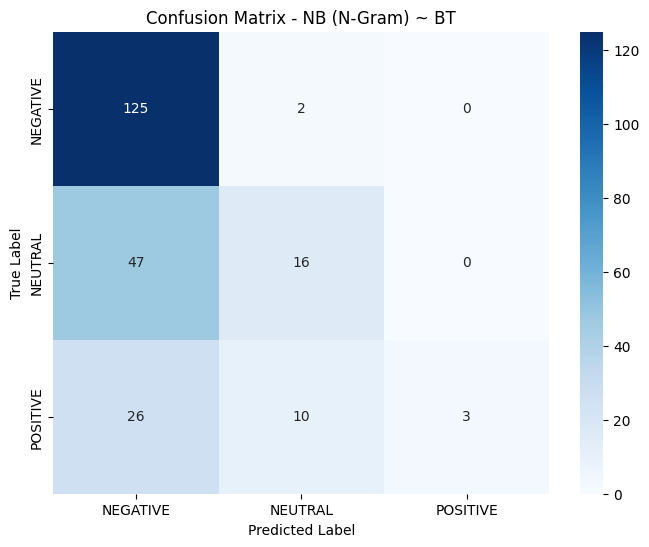

In [ ]:
print("\nAkurasi:", accuracy_score(y_test, y_predict))
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n', confusion_matrix(y_test,y_predict))

for label in sorted(y_test.unique()):
    mask = y_test == label
    class_acc = accuracy_score(y_test[mask], y_predict[mask])
    class_count = mask.sum()
    print(f"Kelas {label}: Akurasi = {class_acc:.4f} ({class_acc*100:.2f}%) | Samples = {class_count}")

# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=uniques, yticklabels=uniques)
plt.title('Confusion Matrix - NB (N-Gram) ~ BT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



---


NB Pakai TF-IDF (BT)


---



In [ ]:
x_train = df_train['clean_text']
y_train = df_train['label_sentimen_encoded']

x_test = df_test['clean_text']
y_test = df_test['label_sentimen_encoded']

# TF-IDF
tfidf = TfidfVectorizer(use_idf = True)
x_train_vec = tfidf.fit_transform(x_train)
x_test_vec = tfidf.transform(x_test)

print(x_train_vec.shape)
print(x_test_vec.shape)

# Naive-Bayes (TF-IDF)
nb_tfidf = MultinomialNB()
nb_tfidf.fit(x_train_vec, y_train) # model

# Melakukan prediksi nilai y pada dataset testing
y_predict = nb_tfidf.predict(x_test_vec)
y_prob = nb_tfidf.predict_proba(x_test_vec) [:,1]

print(y_predict)

In [ ]:
print("\nAkurasi:", accuracy_score(y_test, y_predict))
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n', confusion_matrix(y_test,y_predict))

for label in sorted(y_test.unique()):
    mask = y_test == label
    class_acc = accuracy_score(y_test[mask], y_predict[mask])
    class_count = mask.sum()
    print(f"Kelas {label}: Akurasi = {class_acc:.4f} ({class_acc*100:.2f}%) | Samples = {class_count}")

---

NB Pakai N-Gram (~ BT)

---

In [ ]:
x_train = df_train_bef['clean_text']
y_train = df_train_bef['label_sentimen_encoded']

x_test = df_test_bef['clean_text']
y_test = df_test_bef['label_sentimen_encoded']

# TF-IDF (vectorization) n-gram
tfidf = TfidfVectorizer(
    max_features=None,
    ngram_range = (1,2)
    )
x_train_vec = tfidf.fit_transform(x_train)
x_test_vec = tfidf.transform(x_test)

print(x_train_vec.shape)
print(x_test_vec.shape)

'''class distribution
'''
print(y_train.value_counts())
print(f"Jumlah data train: {x_train_vec.shape[0]}")

# fine tunning
param_grid = {'alpha': [0.001,0.01,0.1,0.5,1.0,2.0,5.0,10.0]}
nb_grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1_weighted')
nb_grid.fit(x_train_vec, y_train)

print(f"Best parameter: {nb_grid.best_params_}")
print(f"Best score: {nb_grid.best_score_}")
nb_model = nb_grid.best_estimator_

# prediksi pada data Test
y_predict = nb_model.predict(x_test_vec)
print(y_predict[:10])

In [ ]:
print("\nAkurasi:", accuracy_score(y_test, y_predict))
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n', confusion_matrix(y_test,y_predict))

for label in sorted(y_test.unique()):
    mask = y_test == label
    class_acc = accuracy_score(y_test[mask], y_predict[mask])
    class_count = mask.sum()
    print(f"Kelas {label}: Akurasi = {class_acc:.4f} ({class_acc*100:.2f}%) | Samples = {class_count}")

# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=uniques, yticklabels=uniques)
plt.title('Confusion Matrix - SVM (N-Gram)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

---

NB Pakai N-Gram (BT)

---

In [ ]:
x_train = df_train['clean_text']
y_train = df_train['label_sentimen_encoded']

x_test = df_test['clean_text']
y_test = df_test['label_sentimen_encoded']

# TF-IDF (vectorization) n-gram
tfidf = TfidfVectorizer(
    max_features=None,
    ngram_range = (1,2)
    )
x_train_vec = tfidf.fit_transform(x_train)
x_test_vec = tfidf.transform(x_test)

print(x_train_vec.shape)
print(x_test_vec.shape)

'''class distribution
'''
print(y_train.value_counts())
print(f"Jumlah data train: {x_train_vec.shape[0]}")

# fine tunning
param_grid = {'alpha': [0.001,0.01,0.1,0.5,1.0,2.0,5.0,10.0]}
nb_grid = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring='f1_weighted')
nb_grid.fit(x_train_vec, y_train)

print(f"Best parameter: {nb_grid.best_params_}")
print(f"Best score: {nb_grid.best_score_}")
nb_model = nb_grid.best_estimator_

# prediksi pada data Test
y_predict = nb_model.predict(x_test_vec)
print(y_predict[:10])

(769, 13928)
(330, 13928)
label_sentimen_encoded
0    297
1    291
2    181
Name: count, dtype: int64
Jumlah data train: 769
Best parameter: {'alpha': 0.001}
Best score: 0.801772303794672
[1 0 1 1 1 1 0 1 2 1]



Akurasi: 0.8484848484848485
              precision    recall  f1-score   support

           0       0.94      0.84      0.89       128
           1       0.78      0.90      0.83       125
           2       0.85      0.78      0.81        77

    accuracy                           0.85       330
   macro avg       0.85      0.84      0.84       330
weighted avg       0.86      0.85      0.85       330

Confusion Matrix:
 [[108  17   3]
 [  5 112   8]
 [  2  15  60]]
Kelas 0: Akurasi = 0.8438 (84.38%) | Samples = 128
Kelas 1: Akurasi = 0.8960 (89.60%) | Samples = 125
Kelas 2: Akurasi = 0.7792 (77.92%) | Samples = 77


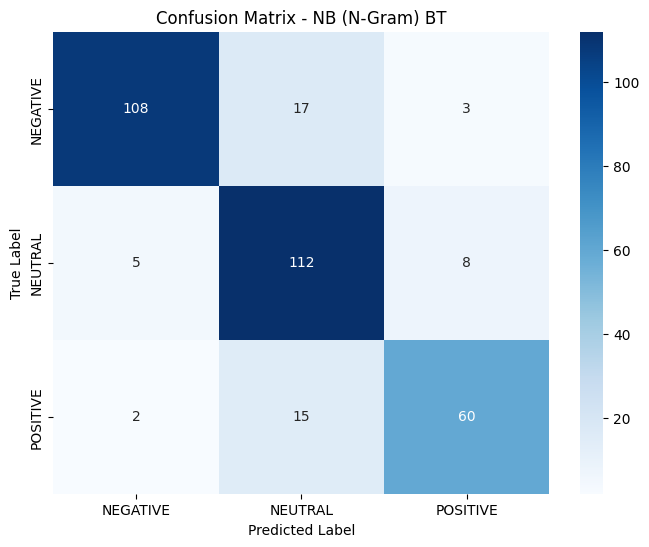

In [ ]:
print("\nAkurasi:", accuracy_score(y_test, y_predict))
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n', confusion_matrix(y_test,y_predict))

for label in sorted(y_test.unique()):
    mask = y_test == label
    class_acc = accuracy_score(y_test[mask], y_predict[mask])
    class_count = mask.sum()
    print(f"Kelas {label}: Akurasi = {class_acc:.4f} ({class_acc*100:.2f}%) | Samples = {class_count}")

# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=uniques, yticklabels=uniques)
plt.title('Confusion Matrix - NB (N-Gram) BT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Model Suppoer Vector Machine



---

SVM Pakai N-Gram (~BT)

---



In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

x_train = df_train_bef['clean_text']
y_train = df_train_bef['label_sentimen_encoded']

x_test = df_test_bef['clean_text']
y_test = df_test_bef['label_sentimen_encoded']

# TF-IDF (vectorization) n-gram
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range = (1,2),
    min_df = 2
    )

x_train_vec = tfidf.fit_transform(x_train)
x_test_vec = tfidf.transform(x_test)

print(x_train_vec.shape)
print(x_test_vec.shape)

'''Fine Tuning
'''
# defining parameter range
param_grid_lin = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear']
}

grid_lin = GridSearchCV(
    svm.SVC(random_state = 42),
    param_grid_lin, # Changed from param_grid to param_grid_lin
    cv = 5,
    scoring = 'f1_weighted',
    refit = True,
    verbose = 3,
    n_jobs=-1
)

grid_lin.fit(x_train_vec, y_train)

param_grid_rbf = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf']
}

grid_rbf = GridSearchCV(
    svm.SVC(random_state = 42),
    param_grid_rbf,
    cv=5,
    scoring='f1_weighted',
    refit=True,
    verbose=2,
    n_jobs=-1
)

grid_rbf.fit(x_train_vec, y_train)

if grid_lin.best_score_ > grid_rbf.best_score_:
    grid = grid_lin.best_estimator_
    print("\nPakai Linear kernel")
else:
    grid = grid_rbf.best_estimator_
    print("\nPakai RBF kernel")

y_predict = grid.predict(x_test_vec)

(534, 2575)
(229, 2575)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Pakai RBF kernel



Akurasi: 0.6768558951965066
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       127
           1       0.53      0.54      0.54        63
           2       0.54      0.36      0.43        39

    accuracy                           0.68       229
   macro avg       0.61      0.58      0.59       229
weighted avg       0.66      0.68      0.67       229

Confusion Matrix:
 [[107  16   4]
 [ 21  34   8]
 [ 11  14  14]]
Kelas 0: Akurasi = 0.8425 (84.25%) | Samples = 127
Kelas 1: Akurasi = 0.5397 (53.97%) | Samples = 63
Kelas 2: Akurasi = 0.3590 (35.90%) | Samples = 39


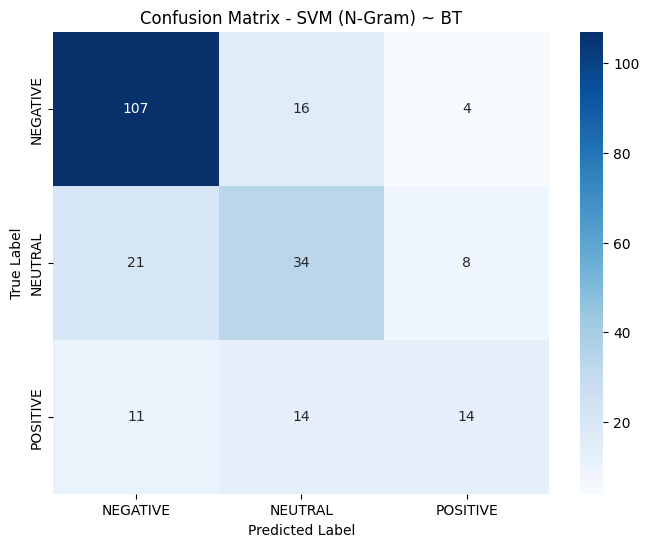

In [ ]:
print("\nAkurasi:", accuracy_score(y_test, y_predict))
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n', confusion_matrix(y_test,y_predict))

for label in sorted(y_test.unique()):
    mask = y_test == label
    class_acc = accuracy_score(y_test[mask], y_predict[mask])
    class_count = mask.sum()
    print(f"Kelas {label}: Akurasi = {class_acc:.4f} ({class_acc*100:.2f}%) | Samples = {class_count}")

# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=uniques, yticklabels=uniques)
plt.title('Confusion Matrix - SVM (N-Gram) ~ BT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



---
SVM Pakai N-Gram (BT)


---



In [ ]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

x_train = df_train['clean_text']
y_train = df_train['label_sentimen_encoded']

x_test = df_test['clean_text']
y_test = df_test['label_sentimen_encoded']

# TF-IDF (vectorization) n-gram
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range = (1,2),
    min_df = 2
    )

x_train_vec = tfidf.fit_transform(x_train)
x_test_vec = tfidf.transform(x_test)

print(x_train_vec.shape)
print(x_test_vec.shape)

'''Fine Tuning
'''
# defining parameter range
param_grid_lin = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['linear']
}

grid_lin = GridSearchCV(
    svm.SVC(random_state = 42),
    param_grid_lin, # Changed from param_grid to param_grid_lin
    cv = 5,
    scoring = 'f1_weighted',
    refit = True,
    verbose = 3,
    n_jobs=-1
)

grid_lin.fit(x_train_vec, y_train)

param_grid_rbf = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['linear', 'rbf']
}

grid_rbf = GridSearchCV(
    svm.SVC(random_state = 42),
    param_grid_rbf,
    cv=5,
    scoring='f1_weighted',
    refit=True,
    verbose=2,
    n_jobs=-1
)

grid_rbf.fit(x_train_vec, y_train)

if grid_lin.best_score_ > grid_rbf.best_score_:
    grid = grid_lin.best_estimator_
    print("\nPakai Linear kernel")
else:
    grid = grid_rbf.best_estimator_
    print("\nPakai RBF kernel")

y_predict = grid.predict(x_test_vec)

(769, 4041)
(330, 4041)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Pakai RBF kernel



Akurasi: 0.8151515151515152
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       128
           1       0.74      0.84      0.79       125
           2       0.91      0.75      0.82        77

    accuracy                           0.82       330
   macro avg       0.83      0.81      0.82       330
weighted avg       0.82      0.82      0.82       330

Confusion Matrix:
 [[106  21   1]
 [ 15 105   5]
 [  4  15  58]]
Kelas 0: Akurasi = 0.8281 (82.81%) | Samples = 128
Kelas 1: Akurasi = 0.8400 (84.00%) | Samples = 125
Kelas 2: Akurasi = 0.7532 (75.32%) | Samples = 77


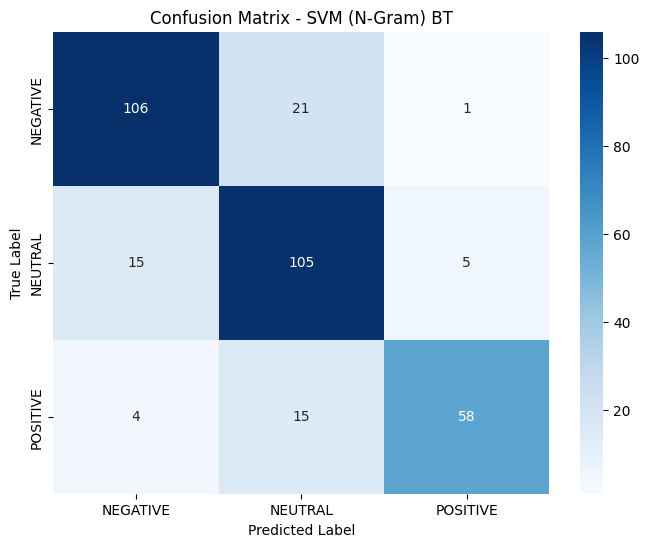

In [ ]:
print("\nAkurasi:", accuracy_score(y_test, y_predict))
print(classification_report(y_test,y_predict))
print('Confusion Matrix:\n', confusion_matrix(y_test,y_predict))

for label in sorted(y_test.unique()):
    mask = y_test == label
    class_acc = accuracy_score(y_test[mask], y_predict[mask])
    class_count = mask.sum()
    print(f"Kelas {label}: Akurasi = {class_acc:.4f} ({class_acc*100:.2f}%) | Samples = {class_count}")

# Visualize Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=uniques, yticklabels=uniques)
plt.title('Confusion Matrix - SVM (N-Gram) BT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# D. Topic Modeling

Stopword removal

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

stopword = [
    'bp', 'pada', 'ini', 'itu', 'dan', 'yang', 'di', 'ke', 'dari', 'untuk',
    'akan', 'bisa', 'ada', 'saat', 'soal', 'oleh', 'secara', 'lu',
    'gue', 'gw', 'baca', 'selengkapnya'
]

text_negatif = pd.concat([df_train[df_train['label_sentimen_encoded']==0]['clean_text'],
                          df_test[df_test['label_sentimen_encoded']==0]['clean_text']]).astype(str)
text_combined = " ".join(text_negatif.tolist())

text = " ".join(text_negatif.tolist())
word_cloud = WordCloud(collocations = False, background_color = "white", stopwords=stopword, colormap="Reds")
word_cloud.generate(text_combined)

# display the generated word
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

1. Tokenisasi

In [ ]:
pip install gensim

In [ ]:
import gensim
import gensim.corpora as corpora

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_words = list(sent_to_words(text_negatif))

2. Dictionary

In [ ]:
# create dictionary
id2word = corpora.Dictionary(data_words)
id2word.filter_extremes(no_below=3, no_above=0.85)

# create corpus
# term frequency
corpus = [id2word.doc2bow(text) for text in data_words]
# view
[[(id2word[id], freq) for id,freq in cp] for cp in corpus[:1]]

3. Algoritma Latent Dirichlet Allocation (LDA)

In [ ]:
import gensim
from pprint import pprint

lda_model = gensim.models.LdaMulticore(corpus = corpus,
                                       id2word = id2word,
                                       num_topics = 10,
                                       random_state = 100,
                                       chunksize = 100,
                                       passes = 10,
                                       per_word_topics = True)

pprint(lda_model.print_topics())

In [ ]:
def show_topics(model, num_topics, no_top_words):
  for topic_idx in range(num_topics):
    print(f"Topic #{topic_idx + 1}:")
    topic_words = [word for word, prob in model.show_topic(topic_idx, topn=no_top_words)]
    print(", ".join(topic_words))
    print("-"*20)

print("\nHasil Topic Modeling")
show_topics(lda_model, lda_model.num_topics, 30)



---

proporsi topik per dokumen

---



In [ ]:
print("Topic distribution for doc:", " ".join(data_words[0]))
print("feature of each token: ", [(id2word[id], freq) for id, freq in corpus[0]])
lda_model.get_document_topics(corpus[0])



---
skor koherensi -> mengukur derajat kemiripan semantik dari kata-kata dengan skor tertinggi


---



In [ ]:
from gensim.models.coherencemodel import CoherenceModel

# compute coherence score
coherence_model_lda = CoherenceModel(model = lda_model, texts = data_words, dictionary = id2word,
                                     coherence = 'c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

# melihat skor koherensi per topik
coherence_per_topic = coherence_model_lda.get_coherence_per_topic()
print('Coherence per Topic Score:', coherence_per_topic)



---

visualisasi -> graffik koherensi untuk menentukan banyaknya model topik

---



In [ ]:
# function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
  coherence_values = []
  model_list = []
  for num_topics in range(start, limit, step):
    model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                            id2word = id2word,
                                            num_topics = num_topics,
                                            random_state = 100,
                                            chunksize = 100,
                                            passes = 10,
                                            per_word_topics = True)
    model_list.append(model)
    coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary,
                                    coherence = 'c_v')
    coherence_values.append(coherencemodel.get_coherence())

  return model_list, coherence_values

start = 1
limit = 11
step = 1
model_list, coherence_values = compute_coherence_values(id2word, corpus, data_words, start = start, limit = limit, step = step)

# graphs
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Berdasarkan graffik tersebut, maka pengelompokan topik yang optimal adalah 3 topik.

In [ ]:
pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim_models
import pickle
import pyLDAvis

lda_model = gensim.models.LdaMulticore(corpus = corpus,
                                       id2word = id2word,
                                       num_topics = 3,
                                       random_state = 100,
                                       chunksize = 100,
                                       passes = 10,
                                       per_word_topics = True)

pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared